In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import geopy.distance
from scipy.interpolate import Rbf
from pykrige import OrdinaryKriging

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

**data retrieval functions:**

In [2]:
# global constant for SWE columns
SWE_COLS = 3

In [3]:
def normalize_SWE_COLS(columns):
    """
    return columns without date columns " HH:MM:SS" suffix
    
    return: list of processed columns
    """
    
    return list(columns[:SWE_COLS]) + [col[:-9] for col in columns[SWE_COLS:]]

In [4]:
def get_train_metadata(input_path, metadata_path, key, drop_index=True, norm_cols=True):
    """
    returns input file joined with longitude and latitude metadata
    
    key:        input file column by which to perform the join
    drop_index: remove redundant index column from the input file
    norm_cols:  normalize date columns format
    
    return:     dataframe object with columns of this shape [key, longitude, latitude, [2020-21 date columns]]
    """
    # read files and rename cell id column of metadata dataframe to match with input files' same column using key
    metadata_df = pd.read_csv(metadata_path)[['field_1', 'longitude', 'latitude']].rename(columns = {'field_1': key})
    input_df = pd.read_csv(input_path)
    # remove input dataframes' index if necessary
    if drop_index:
        input_df.drop(columns='Unnamed: 0', inplace=True)
    # merge both dataframes on cell id column, retain only rows that are in input file
    result = metadata_df.merge(input_df, how='right')
    # normalize date columns if necessary
    if norm_cols:
        result.columns = normalize_SWE_COLS(result.columns)
    
    return result

In [5]:
def get_submission_metadata(submission_path, metadata_path):
    """
    returns submission file joined with longitude and latitude metadata
    """
    # read files and rename metadata dataframe columns to match notebooks' format
    metadata_df = pd.read_csv(metadata_path)[['cell_id', 'CentroidX', 'CentroidY']].rename(columns = {'CentroidX': 'longitude',
                                                                                                      'CentroidY': 'latitude'})
    submission_df = pd.read_csv(submission_path)
    # merge both dataframes on cell id column, retain only rows that are in submission file
    return metadata_df.merge(submission_df, how='right')

**prediction functions:**

In [6]:
def interpolate_snapshot(x, y, z, xi, yi, func):
    """
    interpolate SWE at points using rbf/kriging on a specific date
    
    x, y, z: longitude, latitude, swe to interpolate from
    xi, yi:  longitude, latitude to interpolate at
    func:    interpolation tool + specific function
    
    return:  SWE interpolated at (xi, yi) points
    """
    
    func_type = func.split()[0]
    func_ = func.split()[1]

    if  func_type == 'rbf':
        # use scipy.interpolate Rbf with specific function
        interp = Rbf(x, y, z, 
                     function=func_)
        result = interp(xi, yi)
        
    elif func_type  == 'krig':
        # use kriging for interpolation with sepcific variogram model
        OK = OrdinaryKriging(x, y, z,
                             variogram_model=func_,
                             verbose=False,
                             enable_plotting=False)
        result, _ = OK.execute('points', xi, yi)

    return result

In [7]:
def predict(train_set, target_points, inter_func):
    """
    returns predictions over test set coordinates given train test samples
    
    inter_func: saptial interpolation function
    """
    
    preds = target_points.copy()
    cols = list(train_set.columns)
    
    train_long = train_set.loc[:, 'longitude']
    train_lat = train_set.loc[:, 'latitude']    
    for i in range(3, 60):
        date_swe = train_set.iloc[:, i]
        date = cols[i]

        preds[date] = interpolate_snapshot(train_long, train_lat, date_swe, 
                                    preds['longitude'], preds['latitude'], 
                                    inter_func)
    
    return preds

In [8]:
def cross_validate(data_points, methods, target=None, return_best=False, n=5):
    """
    performing cross validation over data points using given methods.
    return performances report and predictions of target if requested
    
    data_points: training data
    methods:     list of predicting methods
    n:           number of splits for cross validation
    return_best: if true, return target predictions of best method
    target:      data points to predict SWE on for submission to site
    
    return: dataframe with performances over given methods,
            dataframe with target predictions of best method
    """
    # initialize KFold object for splitting data points and metric dictionaries
    kf = KFold(n_splits=n)
    split_rmse = {func: [] for func in methods}
    split_r2 = {func: [] for func in methods}
    
    for train_index, test_index in kf.split(data_points):
        # initilize train and test sets with KFold split
        train_set = data_points.loc[train_index, :]
        test_set = data_points.loc[test_index, :]
        
        for func in methods:
            # predict using specific method and clip negative SWE predictions
            pred = predict(train_set, test_set, func)
            pred.iloc[:, SWE_COLS:] = np.clip(pred.iloc[:, SWE_COLS:], 0, None)
            # save metrics of this split in list of this specific method in dictionaries
            split_rmse[func].append(mean_squared_error(test_set.iloc[:, SWE_COLS:],
                                                       pred.iloc[:, SWE_COLS:],
                                                       squared=False))
            split_r2[func].append(r2_score(test_set.iloc[:, SWE_COLS:],
                                           pred.iloc[:, SWE_COLS:]))
    # for each method, aggregate all split scores using mean and std 
    rmse_agg = [(func, np.mean(rmses), np.std(rmses))
                   for func, rmses in split_rmse.items()]
    r2_agg = [(func, np.mean(r2s), np.std(r2s))
                 for func, r2s in split_r2.items()]
    # convert aggregated scores to lists for report dataframe columns
    funcs, rmse_means, rmse_stds, r2_means, r2_stds = list(), list(), list(), list(), list()
    for (func, rmse_mean, rmse_std), (func, r2_mean, r2_std) in zip(rmse_agg, r2_agg):
        funcs.append(func)
        rmse_means.append(rmse_mean)
        rmse_stds.append(rmse_std)
        r2_means.append(r2_mean)
        r2_stds.append(r2_std)
    
    report_df = pd.DataFrame({'method': funcs,
                              'RMSE mean': rmse_means, 'RMSE std': rmse_stds, 
                              'R2 mean': r2_means, 'R2 std': r2_stds}).sort_values(by='RMSE mean')
    # return target predictions of best method if required
    if return_best and target is not None:
        # best method is the top one, since the dataframe is sorted by mean RMSE
        best_method = report_df.loc[0, 'method']
        # return target predictions in submission format, i.e. [cell_id, [date columns]]
        submission_df = predict(data_points, target, best_method).drop(columns=['longitude', 'latitude'])
        
        return report_df, submission_df

    return report_df

**visualization functions:**

In [9]:
# global constants for resolution of the spatial grid (visualization)
RES_X = 750
RES_Y = 750

In [10]:
def generate_grid(long_co, lat_co):
    """
    return X and Y coordinates of encompassing grid of given longitudes and latitudes
    
    return: longitude values array, latitude values array
    """
    # create meshgrid of all cells around max/min coordinates
    Xmax = long_co.max()
    Xmin = long_co.min()
    Ymax = lat_co.max()
    Ymin = lat_co.min()
    
    Xi = np.linspace(Xmin, Xmax, RES_X)
    Yi = np.linspace(Ymin, Ymax, RES_Y)
    Xi, Yi = np.meshgrid(Xi, Yi)
    # flatten the vectors of the meshgrid for usage and invert the latitudes for better visualization
    Xi, Yi = Xi.flatten(), Yi.flatten()
    Yi = Yi[::-1]
    
    # using geopy to get size of grid cells in kilometers
    res_X_ = (Xmax - Xmin) / RES_X
    res_Y_ = (Ymax - Ymin) / RES_Y
    
    step_x_km = geopy.distance.geodesic((Ymax, Xmax+res_X_), (Ymax, Xmax)).km
    step_y_km = geopy.distance.geodesic((Ymax+res_Y_, Xmax), (Ymax, Xmax)).km

    print(f'''grid spatial attributes:
    
    minimum longitude:\t{Xmin:.2f},\tmaximum longitude:\t{Xmax:.2f}
    minimum latitude:\t{Ymin:.2f},  \tmaximum latitude:\t{Ymax:.2f}

    cell size is ~{step_x_km:.1f} by ~{step_y_km:.1f} (kilometers)''')
    
    return Xi, Yi

In [11]:
def plot_points(train_points=None, test_points=None, submission_points=None, 
                interpolate=False, inter_date='2020-01-07', inter_func='rbf linear',
                figsize=(10,10)):
    """
    plots given points (longitue vs latitude)
    if any data parameter is missing don't plot it
    
    interpolate: if True, plot swe interpolation over the map (works only with rbf)
    inter_date:  date on which to predict and plot interpolation
    inter_func:  function for interpolation (excepts longitude, latitude, swe, X coordinates, Y coordinates)
    """
    
    plt.figure(figsize=figsize)
    
    # grid interpolation works only with rbf due to high memory usage of kriging 
    if interpolate and inter_func.split()[0] == 'rbf':
        # generate grid around all given points
        all_points = pd.concat([train_points, test_points], axis=0)
        grid_long, grid_lat = generate_grid(all_points['longitude'], all_points['latitude'])
        # interpolate grid and reshape it according to grid resolution variables
        grid_data = interpolate_snapshot(train_points.loc[:, 'longitude'], 
                                         train_points.loc[:, 'latitude'], 
                                         train_points.loc[:, inter_date], 
                                         grid_long, grid_lat, inter_func)
        grid_data = grid_data.reshape((RES_X, RES_Y))
        plt.imshow(grid_data, extent=(grid_long.min(), grid_long.max(), grid_lat.min(), grid_lat.max()), 
                   cmap='binary')
    
    if submission_points is not None:
        # plot submission points in red
        plt.scatter(submission_points['longitude'], submission_points['latitude'], 
                    c='red', marker='o', s=20, linewidths=0.3, edgecolor='white', alpha=0.3,
                    label='submission points')

    if train_points is not None:
        # plot train points in blue
        train_long = train_points.loc[:, 'longitude']
        train_lat = train_points.loc[:, 'latitude']
        plt.scatter(train_long, train_lat, 
                    c='blue', marker='o', s=20, linewidths=0.3, edgecolor='white', alpha=0.6,
                    label='train points')

    if test_points is not None:
        # plot test points in green
        test_long = test_points.loc[:, 'longitude']
        test_lat = test_points.loc[:, 'latitude']
        plt.scatter(test_long, test_lat, 
                    c='green', marker='o', s=20, linewidths=0.3, edgecolor='white', alpha=0.6,
                    label='test points')
    
    title_text = 'data points' + f' with {inter_func} interpolation on the {inter_date}' if interpolate == True else None
    plt.title(title_text)
    plt.legend()

**code:**

In [12]:
train_df = get_train_metadata(input_path="..\\spatial interpolation input\\Mixed000_20131_655.csv",
                              metadata_path="data files\\train_coords.csv",
                              key='Station')

print(train_df.shape)
train_df.head(1)

(655, 60)


,Station,longitude,latitude,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,-120.792,41.237,2.528025,3.465743,3.869819,5.230849,6.170897,6.985962,7.873066,...,6.08613,2.771337,1.884291,0.977426,0.0,0.027416,0.054832,0.082248,0.109663,0.137079


In [13]:
submission_df = get_submission_metadata(submission_path="data files\\submission_format.csv",
                                        metadata_path="data files\\grid_centroid.csv")

print(submission_df.shape)
submission_df.head(1)

(9066, 60)


,cell_id,longitude,latitude,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,000863e7-21e6-477d-b799-f5675c348627,-119.40616,37.02759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


grid spatial attributes:
    
    minimum longitude:	-123.46,	maximum longitude:	-103.98
    minimum latitude:	32.92,  	maximum latitude:	48.95

    cell size is ~1.9 by ~2.4 (kilometers)


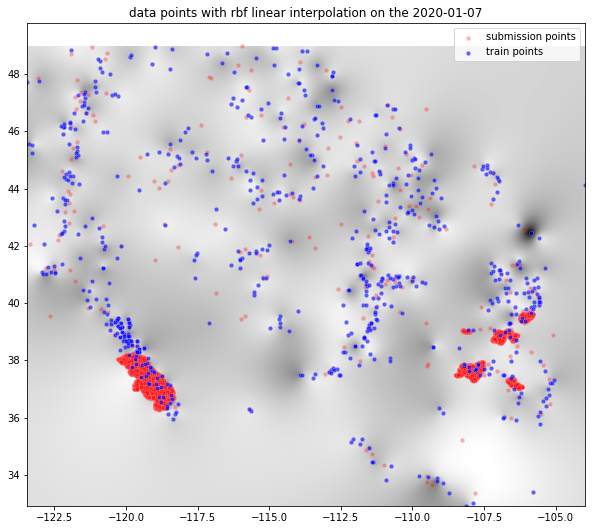

In [14]:
plot_points(train_points=train_df, submission_points=submission_df, interpolate=True)

In [15]:
methods = ['rbf linear', 'rbf thin_plate', 'krig linear', 'krig spherical', 'krig exponential']
# 'rbf multiquadric', 'rbf quintic', 'rbf cubic', 'rbf gaussian', 'rbf inverse',
report_df, submission_pred = cross_validate(train_df, methods, submission_df, return_best=True, n=3)
report_df

,method,RMSE mean,RMSE std,R2 mean,R2 std
2,krig linear,7.746909,0.443179,-0.040039,0.020723
3,krig spherical,7.778814,0.469864,-0.051424,0.020304
4,krig exponential,7.974394,0.444705,-0.091136,0.054932
0,rbf linear,9.215230,0.242713,-0.478713,0.096692
1,rbf thin_plate,18.154318,9.098949,-7.587505,8.725765


In [16]:
print(submission_pred.shape)
submission_pred.head(1)

(9066, 58)


,cell_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,000863e7-21e6-477d-b799-f5675c348627,3.006074,3.450765,3.751557,4.658193,5.21709,6.20446,6.502972,7.094363,7.581166,...,6.681225,4.41997,2.660942,1.729915,0.62343,0.354331,0.230972,-0.175152,-0.019713,0.230639


In [17]:
output_path = "..\\spatial interpolation output\\Mixed000_20131_655_preds.csv"

submission_pred.to_csv(output_path, index=False)